Finally, a new hope ...

# Coarsen Data Part IV: 
Binary map & Coarsen USDM

adi stein, 3.15.2023

In [1]:
import xarray as xr
import numpy as np
import dask
import dask.array as da

import sys
sys.path.append('../../')

import ndrought.wrangle as ndw

import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from ndrought.plotting import usdm_cmap

/pool0/data/steinjao/drought/drought_impact/notebooks/explore/../../ndrought/wrangle.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Load in Data

In [2]:
usdm_da = xr.open_dataset('/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/usdm/USDM_CONUS_105W_20000104_20220412.nc')['USDM'].load()

Found that using `coarsen` to apply a method leaded to some strange results in outputting that couldn't figure out and seemed out of my control ... but it is helpful for windowing our data.

In [3]:
usdm_da_windowed = usdm_da.coarsen({'x':10, 'y':10}, boundary='trim').construct(
    x=("x_coarse", "x_window"),
    y=("y_coarse", "y_window")
)

In [4]:
usdm_da_windowed

<xarray.DataArray 'USDM' (time: 1163, y_coarse: 121, y_window: 10, x_coarse: 89, x_window: 10)>
array([[[[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
...
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]]]])
Coordinates:
    x        (x_coarse, x_window) float64 -2.955e+06 -2.952e+06 ... -6.774e+05
    y        (y_coarse, y_window) float64 3.281e+06 3.279e+06 ... 1.841e+05
  * time     (time) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
Dimensions without coordinates: y_coarse, y_window, x_coarse, x_window
Attributes:
    crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    GeoTransform:                 -125.12090760646159 0.025 0.0 49.6355481069...
    grid_mapping:                 spatial_ref

Let's then start with defining mode before getting to DCVW, since it's part of the method

In [5]:
def mode(a):
    uniq = np.unique(a, return_counts=True)
    return uniq[0][np.argmax(uniq[1])]

In [6]:
test = np.tril((2,2,2))
test

array([[2, 0, 0],
       [2, 2, 0],
       [2, 2, 2]])

In [7]:
test[test<=1] = 0
test[test>1] = 1
test

array([[1, 0, 0],
       [1, 1, 0],
       [1, 1, 1]])

In [8]:
def threshold(a, thresh):
    b = a.copy()
    b[b<thresh] = 0
    b[b>=thresh] = 1
    return b

Now to loop through our data and compute the mode. We'll reshape after.

In [12]:
ny = usdm_da_windowed['y_coarse']
nx = usdm_da_windowed['x_coarse']
times = usdm_da_windowed['time']

prog = tqdm(total=(len(ny)*len(nx)))

all_d1_subs = []
all_d2_subs = []
all_d3_subs = []
all_d4_subs = []
#for t in times: # only going to run it for one time for now to speed up (otherwise 2 hrs)
for yy in ny:
    for xx in nx:
        window = usdm_da_windowed.sel(time='2015-01-06', y_coarse=yy, x_coarse=xx).values
        all_d1_subs.append(mode(threshold(window, 1)))
        all_d2_subs.append(mode(threshold(window, 2)))
        all_d3_subs.append(mode(threshold(window, 3)))
        all_d4_subs.append(mode(threshold(window, 4)))
        window = None
        prog.update()

  0%|          | 0/10769 [00:00<?, ?it/s]

In [13]:
# bit of hard coding for our example
d1_reshaped = np.reshape(np.array(all_d1_subs), (1, 121, 89))
d2_reshaped = np.reshape(np.array(all_d2_subs), (1, 121, 89))
d3_reshaped = np.reshape(np.array(all_d3_subs), (1, 121, 89))
d4_reshaped = np.reshape(np.array(all_d4_subs), (1, 121, 89))

Let's now take a look at a plot

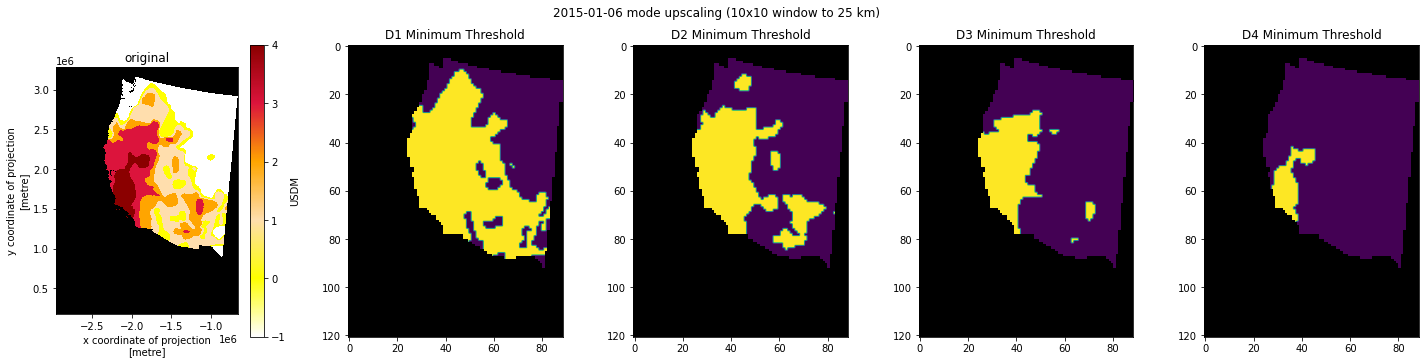

In [17]:
fig, axs = plt.subplots(1, 5, figsize=(20,5))

usdm_da.sel(time='2015-01-06').plot(vmin=-1, vmax=4, cmap=usdm_cmap(), ax=axs[0])
axs[0].set_title('original')

for data, name, ax in zip([d1_reshaped, d2_reshaped, d3_reshaped, d4_reshaped], ['D1', 'D2', 'D3', 'D4'], axs[1:]):
    ax.imshow(data[0, :, :])
    ax.set_title(f'{name} Minimum Threshold')

for ax in axs:
    ax.set_aspect('equal')
    ax.set_facecolor('k')

fig.suptitle('2015-01-06 mode upscaling (10x10 window to 25 km)')
fig.set_facecolor('w')
plt.tight_layout()

That looks pretty good!

In [27]:
xr.Dataset(
    data_vars=dict(
        d1_thresh=(["time", "y", "x"], d1_reshaped),
        d2_thresh=(["time", "y", "x"], d2_reshaped),
        d3_thresh=(["time", "y", "x"], d3_reshaped),
        d4_thresh=(["time", "y", "x"], d4_reshaped)
    ),
    coords = dict(
        time=[1],
        y=usdm_da_windowed.y_coarse.values,
        x=usdm_da_windowed.x_coarse.values
    )
)

<xarray.Dataset>
Dimensions:    (time: 1, y: 121, x: 89)
Coordinates:
  * time       (time) int64 1
  * y          (y) int64 0 1 2 3 4 5 6 7 8 ... 113 114 115 116 117 118 119 120
  * x          (x) int64 0 1 2 3 4 5 6 7 8 9 ... 79 80 81 82 83 84 85 86 87 88
Data variables:
    d1_thresh  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    d2_thresh  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    d3_thresh  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    d4_thresh  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan

In [28]:
usdm_da_windowed.attrs

{'crs_wkt': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]',
 'semi_major_axis': 6378137.0,
 'semi_minor_axis': 6356752.314245179,
 'inverse_flattening': 298.257223563,
 'reference_ellipsoid_name': 'WGS 84',
 'longitude_of_prime_meridian': 0.0,
 'prime_meridian_name': 'Greenwich',
 'geographic_crs_name': 'WGS 84',
 'grid_mapping_name': 'latitude_longitude',
 'spatial_ref': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]',
 'GeoTransform': '-125.12090760646159 0.025 0.0 49.6355481069